In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
import random

### 1. Loading data, summary statistics and visualization

   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0    -0.294118  0.487437       0.180328      -0.292929 -1.000000  0.001490   
1    -0.882353 -0.145729       0.081967      -0.414141 -1.000000 -0.207153   
2    -0.058824  0.839196       0.049180      -1.000000 -1.000000 -0.305514   
3    -0.882353 -0.105528       0.081967      -0.535354 -0.777778 -0.162444   
4    -1.000000  0.376884      -0.344262      -0.292929 -0.602837  0.284650   

   DiabetesPedigreeFunction       Age  Target  
0                 -0.531170 -0.033333       1  
1                 -0.766866 -0.666667       0  
2                 -0.492741 -0.633333       1  
3                 -0.923997 -1.000000       0  
4                  0.887276 -0.600000       1  

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean     -0.547641    0.215020       0.132877      -0.585122   -0.811349   
std       0.39

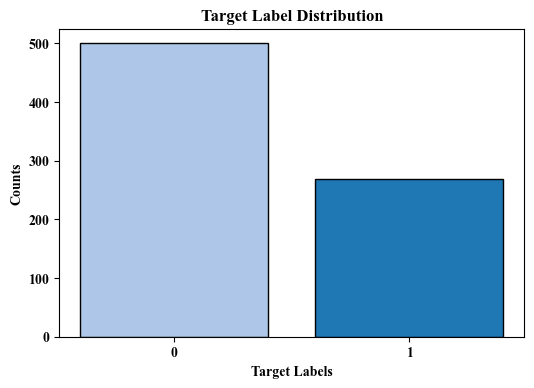

In [2]:
# Providing the path to the LibSVM file
dataset_file = 'diabetes_scale'

# Load data from LibSVM format using scikit-learn
data, targets = load_svmlight_file(dataset_file)
data = data.toarray()  # Convert to dense numpy array
targets = np.where(targets == -1, 1, 0)  # Recode to handle diabetes and no diabetes

# Feature names from the original Pima Indians Diabetes dataset
feature_names = [
    'Pregnancies', 
    'Glucose', 
    'BloodPressure', 
    'SkinThickness', 
    'Insulin', 
    'BMI', 
    'DiabetesPedigreeFunction', 
    'Age'
]

all_data = pd.DataFrame(data,columns=feature_names)
all_data['Target'] = targets
print(all_data.head())
print()
# data summary
print(all_data.describe())
print()
#Checking for missing data
print(all_data.isnull().sum())
print()
unique, counts = np.unique(all_data['Target'], return_counts=True)
print(dict(zip(unique, counts)))

# Colors for 0 and 1 labels
colors = ['#aec7e8','#1f77b4'] 
# Define the font properties
font = {'family': 'Times New Roman', 'weight': 'bold', 'size': 10}
plt.rc('font', **font) 
# Create the bar plot
plt.figure(figsize=(6, 4))
plt.bar(unique, counts, color=colors, edgecolor='black')
plt.xlabel('Target Labels', fontsize=10, weight='bold')
plt.ylabel('Counts', fontsize=10, weight='bold')
plt.title('Target Label Distribution', fontsize=12, weight='bold')
plt.xticks([0, 1])
plt.show()

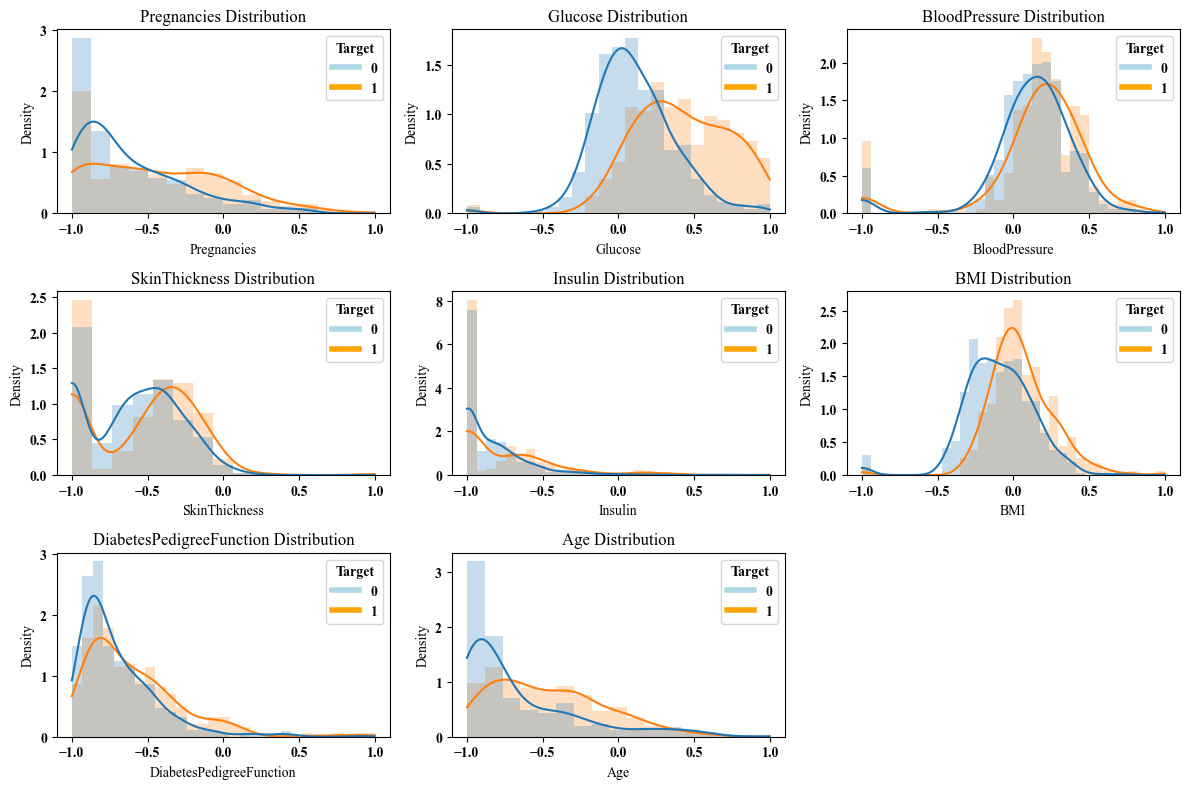

In [3]:
# Visualizing feature distribution
all_data['Target'] = all_data['Target'].astype(int)
plt.figure(figsize=(12, 8))
for i, feature in enumerate(feature_names):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=all_data, x=feature, hue='Target', element='step', kde=True,
                 stat='density', common_norm=False, fill=True, edgecolor=None,legend=False)
    plt.title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Density')
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='lightblue', lw=4, label='0'),
                    Line2D([0], [0], color='orange', lw=4, label='1')]
    plt.legend(handles=custom_lines, title='Target', loc='upper right')

plt.tight_layout()
plt.show()

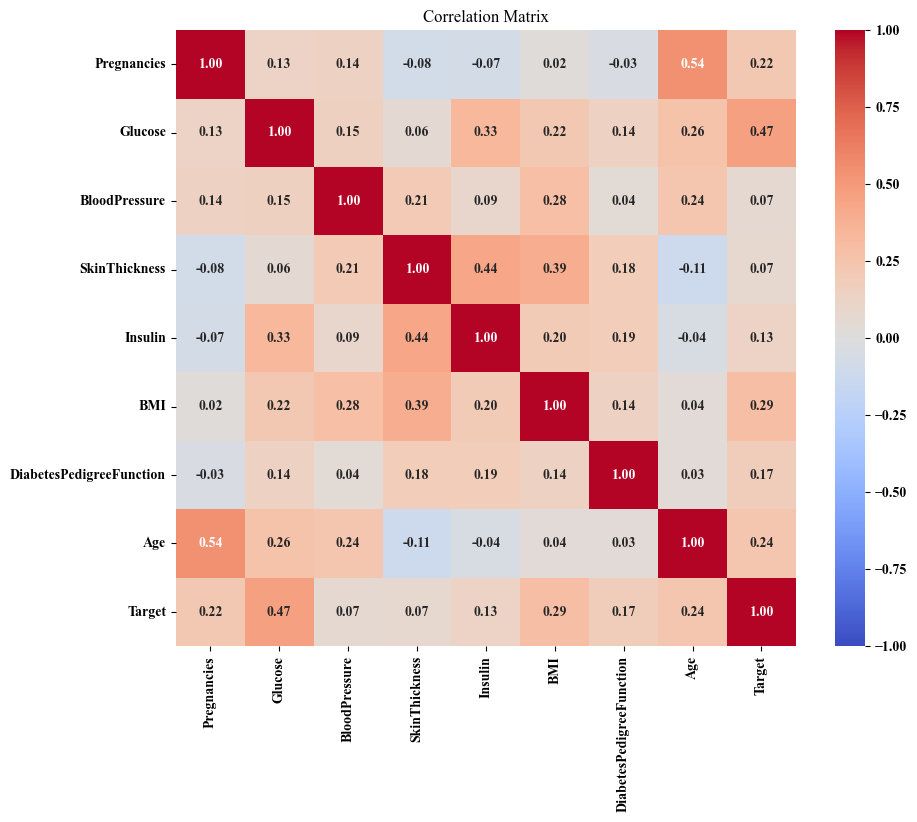

In [4]:
# Checking for correaltion
## Compute the correlation matrix
corr_matrix = all_data.corr() 
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

### 2. Data cleaning - Outlier handling with median imputation

In [5]:
# Custom transformer for handling outliers with IQR and performing median imputation
class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Applying IQR-based outlier detection and median imputation for each feature
        X = pd.DataFrame(X)  # Converting to DataFrame for easier manipulation
        for column in X.columns:
            Q1 = X[column].quantile(0.25)
            Q3 = X[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            median = X[column].median()
            X[column] = np.where((X[column] < lower_bound) | (X[column] > upper_bound), median, X[column])
        return X.values  # Converting back to numpy array 

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.125, stratify=targets, random_state=42)

# Apply outlier handling 
outlier_handler = OutlierHandler()
X_train_transformed = outlier_handler.fit_transform(X_train)
X_test_transformed = outlier_handler.transform(X_test)

### 3. Baseline Model

In [6]:
# Set random seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

# Set a seed 
set_seed(42)

# Custom dataset class for PyTorch
class DiabetesDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data.astype(np.float32)
        self.targets = targets.astype(np.float32)
        
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx], dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        return x, y

# Perceptron class
class Perceptron:
    def __init__(self, input_dim, learning_rate=0.01):
        self.weights = torch.zeros(input_dim + 1, dtype=torch.float32)  # +1 for bias
        self.learning_rate = learning_rate
    
    def predict(self, x):
        x_with_bias = torch.cat((torch.ones(1), x))
        linear_output = torch.dot(self.weights, x_with_bias)
        return 1 if linear_output > 0 else 0
    
    def fit(self, data_loader, epochs=10):
        for epoch in range(epochs):
            for inputs, label in data_loader:
                for i in range(inputs.shape[0]):
                    x = inputs[i]
                    y = label[i].item()
                    prediction = self.predict(x)
                    if prediction != y:
                        update = self.learning_rate * (y - prediction)
                        x_with_bias = torch.cat((torch.ones(1), x))
                        self.weights += update * x_with_bias
                        
# Number of folds for StratifiedKFold
k = 5  # 5 stratified folds
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store performance metrics for each fold
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Perform stratified k-fold cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(X_train_transformed, y_train)):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_transformed[train_index], X_train_transformed[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Convert the fold data to PyTorch tensors
    train_dataset = DiabetesDataset(X_train_transformed, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # Initialize Perceptron (Baseline Model)
    input_dim = X_train_fold.shape[1]
    perceptron = Perceptron(input_dim=input_dim, learning_rate=0.01)
    
    # Train the perceptron for the current fold
    perceptron.fit(train_loader, epochs=10)
    
    # Test the perceptron on the validation fold
    y_pred_fold = [perceptron.predict(torch.tensor(x, dtype=torch.float32)) for x in X_val_fold]
    
    # Calculate performance metrics for the current fold
    accuracy_fold = accuracy_score(y_val_fold, y_pred_fold)
    precision_fold = precision_score(y_val_fold, y_pred_fold)
    recall_fold = recall_score(y_val_fold, y_pred_fold)
    f1_fold = f1_score(y_val_fold, y_pred_fold)
    
    # Append the metrics to the lists
    accuracy_list.append(accuracy_fold)
    precision_list.append(precision_fold)
    recall_list.append(recall_fold)
    f1_list.append(f1_fold)

# Calculate the average performance metrics across all folds
average_accuracy = np.mean(accuracy_list)
average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_f1 = np.mean(f1_list)

# Print the average performance metrics
print('Baseline Model Performance:')
print(f'Accuracy: {average_accuracy*100:.2f}%')
print(f'Precision: {average_precision*100:.2f}%')
print(f'Recall: {average_recall*100:.2f}%')
print(f'F1 Score: {average_f1*100:.2f}%')

Baseline Model Performance:
Accuracy: 69.47%
Precision: 77.99%
Recall: 42.98%
F1 Score: 46.31%


### 4. Experiments

#### 4.1 Performing Experiment 1 - Tuning learning rates and number of ephocs

In [7]:
# Define learning rates and epochs
learning_rates = [0.0001,0.0005,0.001, 0.005, 0.01, 0.05, 0.1]
epochs_list = [10, 20, 50, 80, 100, 150, 200]

# Store experimental results and metrics
experiment_results = [] 
best_f1 = 0
best_model_params = None

# Initialize dictionaries to store metrics for plotting
f1_scores_by_epochs_exp1 = {lr: [] for lr in learning_rates}

# Stratified k-fold setup
k = 5  
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Perform stratified k-fold cross-validation for each learning rate and epoch combination
for lr in learning_rates:
    for epochs in epochs_list:
        fold_accuracy_list = []
        fold_precision_list = []
        fold_recall_list = []
        fold_f1_list = []

        # K-fold cross-validation
        for train_index, val_index in skf.split(X_train_transformed, y_train):
            # Split the data into training and validation sets for the current fold
            X_train_fold, X_val_fold = X_train_transformed[train_index], X_train_transformed[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            
            # Convert to tensors and DataLoader
            train_dataset = DiabetesDataset(X_train_transformed, y_train)
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            
            # Initialize Perceptron with the current learning rate
            experiment_perceptron = Perceptron(input_dim, learning_rate=lr)
            
            # Train the perceptron for the specified number of epochs
            experiment_perceptron.fit(train_loader, epochs=epochs)
            
            # Test the perceptron on the validation fold
            y_pred_fold = [experiment_perceptron.predict(torch.tensor(x, dtype=torch.float32)) for x in X_val_fold]
            
            # Calculate performance metrics for the current fold
            accuracy_fold = accuracy_score(y_val_fold, y_pred_fold)
            precision_fold = precision_score(y_val_fold, y_pred_fold,zero_division = 0)
            recall_fold = recall_score(y_val_fold, y_pred_fold)
            f1_fold = f1_score(y_val_fold, y_pred_fold)
            
            # Store metrics for each fold
            fold_accuracy_list.append(accuracy_fold)
            fold_precision_list.append(precision_fold)
            fold_recall_list.append(recall_fold)
            fold_f1_list.append(f1_fold)

        # Calculate average metrics across all folds for this learning rate and epochs combination
        avg_accuracy = np.mean(fold_accuracy_list)
        avg_precision = np.mean(fold_precision_list)
        avg_recall = np.mean(fold_recall_list)
        avg_f1 = np.mean(fold_f1_list)

        # Store the results
        experiment_results.append((lr, epochs, avg_accuracy, avg_precision, avg_recall, avg_f1))
        
        # Track metrics for plotting
        f1_scores_by_epochs_exp1[lr].append(avg_f1)
        
        # Track the best model based on F1 Score
        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_model_params = (lr, epochs, avg_accuracy, avg_precision, avg_recall, avg_f1)

# Display the experimental results
print('Tuning learning rate and ephocs Experiment Results:')
for lr, epochs, accuracy, precision, recall, f1 in experiment_results:
    print(f'Learning Rate: {lr}, Epochs: {epochs}')
    print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

Tuning learning rate and ephocs Experiment Results:
Learning Rate: 0.0001, Epochs: 10
Accuracy: 0.72, Precision: 0.61, Recall: 0.63, F1 Score: 0.60
Learning Rate: 0.0001, Epochs: 20
Accuracy: 0.73, Precision: 0.79, Recall: 0.34, F1 Score: 0.44
Learning Rate: 0.0001, Epochs: 50
Accuracy: 0.76, Precision: 0.71, Recall: 0.55, F1 Score: 0.59
Learning Rate: 0.0001, Epochs: 80
Accuracy: 0.72, Precision: 0.71, Recall: 0.54, F1 Score: 0.55
Learning Rate: 0.0001, Epochs: 100
Accuracy: 0.72, Precision: 0.67, Recall: 0.63, F1 Score: 0.61
Learning Rate: 0.0001, Epochs: 150
Accuracy: 0.68, Precision: 0.65, Recall: 0.51, F1 Score: 0.50
Learning Rate: 0.0001, Epochs: 200
Accuracy: 0.69, Precision: 0.69, Recall: 0.50, F1 Score: 0.48
Learning Rate: 0.0005, Epochs: 10
Accuracy: 0.61, Precision: 0.57, Recall: 0.71, F1 Score: 0.56
Learning Rate: 0.0005, Epochs: 20
Accuracy: 0.67, Precision: 0.64, Recall: 0.66, F1 Score: 0.58
Learning Rate: 0.0005, Epochs: 50
Accuracy: 0.76, Precision: 0.74, Recall: 0.51, 

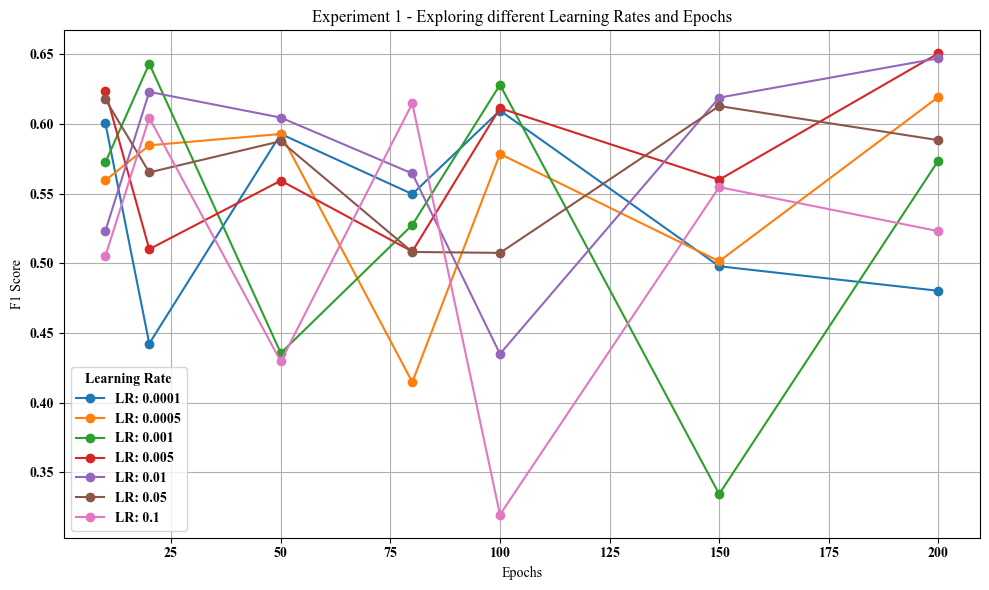

In [8]:
# Plot : Epochs vs F1 Score for different learning rates
plt.figure(figsize=(10, 6))
for lr in learning_rates:
    plt.plot(epochs_list, f1_scores_by_epochs_exp1[lr], marker='o', label=f'LR: {lr}')

plt.title('Experiment 1 - Exploring different Learning Rates and Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# Display the best model based on F1 Score
print('Best Model Parameters after exploration:')
print(f'Learning Rate: {best_model_params[0]}, Epochs: {best_model_params[1]}')
print(f'Accuracy: {best_model_params[2]*100:.2f}%')
print(f'Precision: {best_model_params[3]*100:.2f}%')
print(f'Recall: {best_model_params[4]*100:.2f}%')
print(f'F1 Score: {best_model_params[5]*100:.2f}%')

Best Model Parameters after exploration:
Learning Rate: 0.005, Epochs: 200
Accuracy: 69.63%
Precision: 56.56%
Recall: 81.28%
F1 Score: 65.07%


#### 4.2 Performing Experiment 2 - Mini-batch Gradient Descent with convergence condition

In [10]:
# Define Mini-batch vs Stochastic gradient descent updates and convergence condition
batch_mode = True  # Toggle between batch and SGD updates
convergence_threshold = 1e-4  # Convergence condition for F1 score improvement

# Define learning rates and epochs
learning_rates = [0.0001,0.0005,0.001, 0.005, 0.01, 0.05, 0.1]
epochs_list = [10, 20, 50, 80, 100, 150, 200]

# Store experimental results and metrics
experiment_results = []
best_f1 = 0
best_model_params = None

# Initializing a dictionary to store metrics for plotting
f1_scores_by_epochs_exp2 = {lr: [] for lr in learning_rates}  # F1 scores for plotting

# Stratified k-fold setup
k = 5  
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred,zero_division = 0)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

# Perceptron class with batch/SGD update and convergence condition
class PerceptronWithConvergence:
    def __init__(self, input_dim, learning_rate=0.01):
        self.weights = torch.zeros(input_dim + 1, dtype=torch.float32)  # +1 for bias
        self.learning_rate = learning_rate
    
    def predict(self, x):
        x_with_bias = torch.cat((torch.ones(1), x))
        linear_output = torch.dot(self.weights, x_with_bias)
        return 1 if linear_output > 0 else 0
    
    def fit(self, data_loader, epochs=10, batch_mode=True, convergence_threshold=None):
        previous_f1 = 0
        for epoch in range(epochs):
            epoch_predictions = []
            true_labels = []
            for inputs, label in data_loader:
                for i in range(inputs.shape[0]):
                    x = inputs[i]
                    y = label[i].item()
                    prediction = self.predict(x)
                    epoch_predictions.append(prediction)
                    true_labels.append(y)
                    
                    # Update weights if there's a misclassification (SGD vs batch)
                    if prediction != y:
                        update = self.learning_rate * (y - prediction)
                        x_with_bias = torch.cat((torch.ones(1), x))
                        self.weights += update * x_with_bias

            # Check convergence after each epoch (based on F1 score)
            accuracy, precision, recall, f1 = calculate_metrics(true_labels, epoch_predictions)
            if convergence_threshold and abs(f1 - previous_f1) < convergence_threshold:
                break
            previous_f1 = f1

# Perform stratified k-fold cross-validation
for lr in learning_rates:
    for epochs in epochs_list:
        fold_accuracy_list = []
        fold_precision_list = []
        fold_recall_list = []
        fold_f1_list = []

        for train_index, val_index in skf.split(X_train_transformed, y_train):
            X_train_fold, X_val_fold = X_train_transformed[train_index], X_train_transformed[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            train_dataset = DiabetesDataset(X_train_transformed, y_train)
            train_loader = DataLoader(train_dataset, batch_size=32 if batch_mode else 1, shuffle=True)
            
            # Initialize Perceptron with current learning rate
            experiment_perceptron = PerceptronWithConvergence(input_dim, learning_rate=lr)
            
            # Train the perceptron with stopping criterion and batch/sgd updates
            experiment_perceptron.fit(train_loader, epochs=epochs, batch_mode=batch_mode, convergence_threshold=convergence_threshold)
            
            # Test the perceptron
            y_pred_fold = [experiment_perceptron.predict(torch.tensor(x, dtype=torch.float32)) for x in X_val_fold]
            
            # Calculate performance metrics
            accuracy_fold, precision_fold, recall_fold, f1_fold = calculate_metrics(y_val_fold, y_pred_fold)
            
            fold_accuracy_list.append(accuracy_fold)
            fold_precision_list.append(precision_fold)
            fold_recall_list.append(recall_fold)
            fold_f1_list.append(f1_fold)
        
        # Calculate average metrics across all folds
        avg_accuracy = np.mean(fold_accuracy_list)
        avg_precision = np.mean(fold_precision_list)
        avg_recall = np.mean(fold_recall_list)
        avg_f1 = np.mean(fold_f1_list)

        # Store results
        experiment_results.append((lr, epochs, avg_accuracy, avg_precision, avg_recall, avg_f1))
        f1_scores_by_epochs_exp2[lr].append(avg_f1)

        # Track the best model based on F1 Score
        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_model_params = (lr, epochs, avg_accuracy, avg_precision, avg_recall, avg_f1)

# Display the experimental results
print('Batch gradient descent and convergence condition Experimental Model Results:')
for lr, epochs, accuracy, precision, recall, f1 in experiment_results:
    print(f'Learning Rate: {lr}, Epochs: {epochs}')
    print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

Batch gradient descent and convergence condition Experimental Model Results:
Learning Rate: 0.0001, Epochs: 10
Accuracy: 0.66, Precision: 0.57, Recall: 0.77, F1 Score: 0.63
Learning Rate: 0.0001, Epochs: 20
Accuracy: 0.71, Precision: 0.75, Recall: 0.22, F1 Score: 0.32
Learning Rate: 0.0001, Epochs: 50
Accuracy: 0.69, Precision: 0.74, Recall: 0.44, F1 Score: 0.46
Learning Rate: 0.0001, Epochs: 80
Accuracy: 0.72, Precision: 0.79, Recall: 0.36, F1 Score: 0.45
Learning Rate: 0.0001, Epochs: 100
Accuracy: 0.53, Precision: 0.51, Recall: 0.77, F1 Score: 0.53
Learning Rate: 0.0001, Epochs: 150
Accuracy: 0.72, Precision: 0.81, Recall: 0.40, F1 Score: 0.43
Learning Rate: 0.0001, Epochs: 200
Accuracy: 0.72, Precision: 0.64, Recall: 0.63, F1 Score: 0.61
Learning Rate: 0.0005, Epochs: 10
Accuracy: 0.73, Precision: 0.73, Recall: 0.46, F1 Score: 0.48
Learning Rate: 0.0005, Epochs: 20
Accuracy: 0.75, Precision: 0.77, Recall: 0.43, F1 Score: 0.54
Learning Rate: 0.0005, Epochs: 50
Accuracy: 0.71, Precis

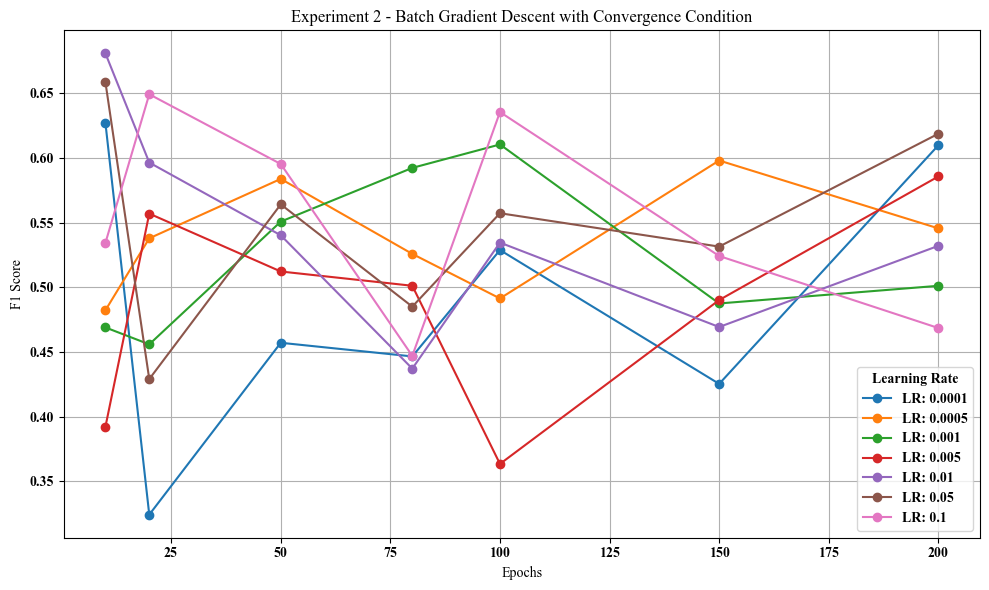

In [11]:
# Plot : Epochs vs F1 Score for different learning rates
plt.figure(figsize=(10, 6))
for lr in learning_rates:
    plt.plot(epochs_list, f1_scores_by_epochs_exp2[lr], marker='o', label=f'LR: {lr}')

plt.title('Experiment 2 - Batch Gradient Descent with Convergence Condition')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# Display the best model based on F1 Score
print('Best Model Parameters when using batch gradient descent and convergence condition:')
print(f'Learning Rate: {best_model_params[0]}, Epochs: {best_model_params[1]}')
print(f'Accuracy: {best_model_params[2]*100:.2f}%')
print(f'Precision: {best_model_params[3]*100:.2f}%')
print(f'Recall: {best_model_params[4]*100:.2f}%')
print(f'F1 Score: {best_model_params[5]*100:.2f}%')

Best Model Parameters when using batch gradient descent and convergence condition:
Learning Rate: 0.01, Epochs: 10
Accuracy: 72.32%
Precision: 58.95%
Recall: 83.40%
F1 Score: 68.10%


#### 4.3 Performing Experiment 3 - Stochastic Gradient Descent (SGD) with convergence condition

In [13]:
# Define batch vs SGD updates and convergence condition
batch_mode = False  # SGD updates
convergence_threshold = 1e-4  # Convergence condition for F1 score improvement

# Define learning rates and epochs
learning_rates = [0.0001,0.0005,0.001, 0.005, 0.01, 0.05, 0.1]
epochs_list = [10, 20, 50, 80, 100, 150, 200]

# Store experimental results and metrics
experiment_results = []
best_f1 = 0
best_model_params = None

# Initialize a dictionary to store metrics for plotting
f1_scores_by_epochs_exp3 = {lr: [] for lr in learning_rates}  # F1 scores for plotting

# Stratified k-fold setup
k = 5  # 5 stratified folds
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred,zero_division = 0)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

# Perceptron class with batch/SGD update and convergence condition
class PerceptronWithConvergence:
    def __init__(self, input_dim, learning_rate=0.01):
        self.weights = torch.zeros(input_dim + 1, dtype=torch.float32)  # +1 for bias
        self.learning_rate = learning_rate
    
    def predict(self, x):
        x_with_bias = torch.cat((torch.ones(1), x))
        linear_output = torch.dot(self.weights, x_with_bias)
        return 1 if linear_output > 0 else 0
    
    def fit(self, data_loader, epochs=10, batch_mode=True, convergence_threshold=None):
        previous_f1 = 0
        for epoch in range(epochs):
            epoch_predictions = []
            true_labels = []
            for inputs, label in data_loader:
                for i in range(inputs.shape[0]):
                    x = inputs[i]
                    y = label[i].item()
                    prediction = self.predict(x)
                    epoch_predictions.append(prediction)
                    true_labels.append(y)
                    
                    # Update weights if there's a misclassification (online vs batch)
                    if prediction != y:
                        update = self.learning_rate * (y - prediction)
                        x_with_bias = torch.cat((torch.ones(1), x))
                        self.weights += update * x_with_bias

            # Check convergence after each epoch (based on F1 score)
            accuracy, precision, recall, f1 = calculate_metrics(true_labels, epoch_predictions)
            if convergence_threshold and abs(f1 - previous_f1) < convergence_threshold:
                break
            previous_f1 = f1

# Perform stratified k-fold cross-validation
for lr in learning_rates:
    for epochs in epochs_list:
        fold_accuracy_list = []
        fold_precision_list = []
        fold_recall_list = []
        fold_f1_list = []

        for train_index, val_index in skf.split(X_train_transformed, y_train):
            X_train_fold, X_val_fold = X_train_transformed[train_index], X_train_transformed[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            train_dataset = DiabetesDataset(X_train_transformed, y_train)
            train_loader = DataLoader(train_dataset, batch_size=32 if batch_mode else 1, shuffle=True)
            
            # Initialize Perceptron with current learning rate
            experiment_perceptron = PerceptronWithConvergence(input_dim, learning_rate=lr)
            
            # Train the perceptron with stopping criterion and batch/online updates
            experiment_perceptron.fit(train_loader, epochs=epochs, batch_mode=batch_mode, convergence_threshold=convergence_threshold)
            
            # Test the perceptron
            y_pred_fold = [experiment_perceptron.predict(torch.tensor(x, dtype=torch.float32)) for x in X_val_fold]
            
            # Calculate performance metrics
            accuracy_fold, precision_fold, recall_fold, f1_fold = calculate_metrics(y_val_fold, y_pred_fold)
            
            fold_accuracy_list.append(accuracy_fold)
            fold_precision_list.append(precision_fold)
            fold_recall_list.append(recall_fold)
            fold_f1_list.append(f1_fold)
        
        # Calculate average metrics across all folds
        avg_accuracy = np.mean(fold_accuracy_list)
        avg_precision = np.mean(fold_precision_list)
        avg_recall = np.mean(fold_recall_list)
        avg_f1 = np.mean(fold_f1_list)

        # Store results
        experiment_results.append((lr, epochs, avg_accuracy, avg_precision, avg_recall, avg_f1))
        f1_scores_by_epochs_exp3[lr].append(avg_f1)

        # Track the best model based on F1 Score
        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_model_params = (lr, epochs, avg_accuracy, avg_precision, avg_recall, avg_f1)

# Display the experimental results
print('SGD updates and convergence condition Experimental Model Results:')
for lr, epochs, accuracy, precision, recall, f1 in experiment_results:
    print(f'Learning Rate: {lr}, Epochs: {epochs}')
    print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

SGD updates and convergence condition Experimental Model Results:
Learning Rate: 0.0001, Epochs: 10
Accuracy: 0.68, Precision: 0.68, Recall: 0.57, F1 Score: 0.51
Learning Rate: 0.0001, Epochs: 20
Accuracy: 0.71, Precision: 0.70, Recall: 0.60, F1 Score: 0.59
Learning Rate: 0.0001, Epochs: 50
Accuracy: 0.75, Precision: 0.79, Recall: 0.49, F1 Score: 0.53
Learning Rate: 0.0001, Epochs: 80
Accuracy: 0.72, Precision: 0.62, Recall: 0.80, F1 Score: 0.68
Learning Rate: 0.0001, Epochs: 100
Accuracy: 0.74, Precision: 0.77, Recall: 0.42, F1 Score: 0.49
Learning Rate: 0.0001, Epochs: 150
Accuracy: 0.72, Precision: 0.68, Recall: 0.64, F1 Score: 0.60
Learning Rate: 0.0001, Epochs: 200
Accuracy: 0.72, Precision: 0.77, Recall: 0.52, F1 Score: 0.52
Learning Rate: 0.0005, Epochs: 10
Accuracy: 0.64, Precision: 0.57, Recall: 0.68, F1 Score: 0.54
Learning Rate: 0.0005, Epochs: 20
Accuracy: 0.68, Precision: 0.72, Recall: 0.49, F1 Score: 0.46
Learning Rate: 0.0005, Epochs: 50
Accuracy: 0.74, Precision: 0.61, 

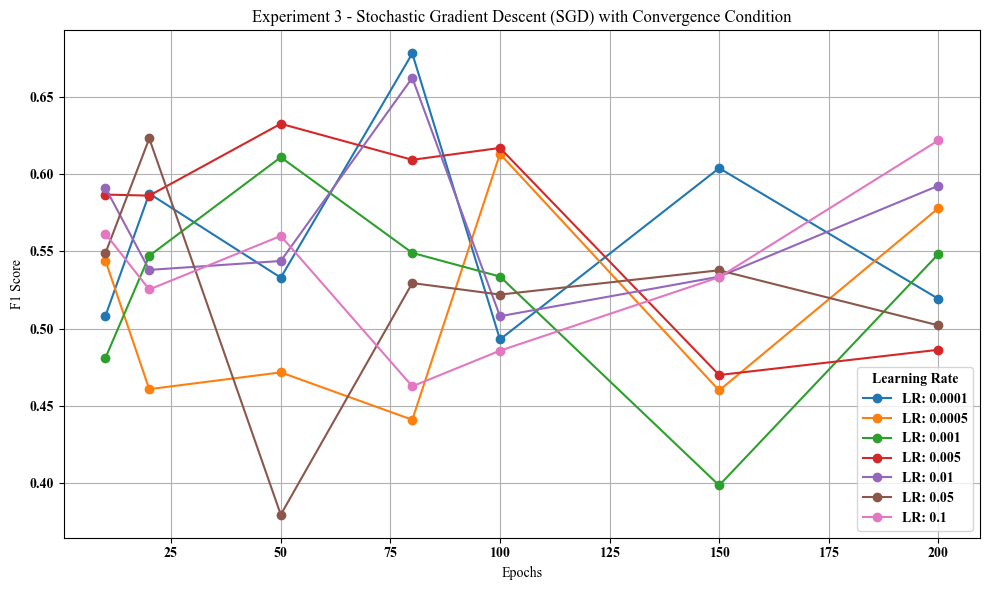

In [14]:
# Plot 1: Epochs vs F1 Score for different learning rates
plt.figure(figsize=(10, 6))
for lr in learning_rates:
    plt.plot(epochs_list, f1_scores_by_epochs_exp3[lr], marker='o', label=f'LR: {lr}')

plt.title('Experiment 3 - Stochastic Gradient Descent (SGD) with Convergence Condition')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Display the best model based on F1 Score
print('Best Model Parameters when using stochastic gradient descent and convergence condition:')
print(f'Learning Rate: {best_model_params[0]}, Epochs: {best_model_params[1]}')
print(f'Accuracy: {best_model_params[2]*100:.2f}%')
print(f'Precision: {best_model_params[3]*100:.2f}%')
print(f'Recall: {best_model_params[4]*100:.2f}%')
print(f'F1 Score: {best_model_params[5]*100:.2f}%')

Best Model Parameters when using stochastic gradient descent and convergence condition:
Learning Rate: 0.0001, Epochs: 80
Accuracy: 72.44%
Precision: 62.20%
Recall: 80.43%
F1 Score: 67.83%


#### 4.4 Performing Experiment 4 - Random weight initialization

In [16]:
# Perceptron class with random weight initialization
class Perceptron:
    def __init__(self, input_dim, learning_rate=0.01):
        self.weights = torch.randn(input_dim + 1, dtype=torch.float32)  # Random initialization for weights (+1 for bias)
        self.learning_rate = learning_rate
    
    def predict(self, x):
        x_with_bias = torch.cat((torch.ones(1), x))  # Add bias term
        linear_output = torch.dot(self.weights, x_with_bias)
        return 1 if linear_output > 0 else 0
    
    def fit(self, data_loader, epochs=10):
        for epoch in range(epochs):
            for inputs, label in data_loader:
                for i in range(inputs.shape[0]):
                    x = inputs[i]
                    y = label[i].item()
                    prediction = self.predict(x)
                    if prediction != y:
                        update = self.learning_rate * (y - prediction)
                        x_with_bias = torch.cat((torch.ones(1), x))
                        self.weights += update * x_with_bias

# Define learning rates and epochs
learning_rates = [0.0001,0.0005,0.001, 0.005, 0.01, 0.05, 0.1]
epochs_list = [10, 20, 50, 80, 100, 150, 200]

# Store experimental results and metrics
experiment_results = []
best_f1 = 0
best_model_params = None

# Initialize dictionaries to store metrics for plotting
f1_scores_by_epochs_exp4 = {lr: [] for lr in learning_rates}

# Stratified k-fold setup
k = 5  
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Perform stratified k-fold cross-validation for each learning rate and epoch combination
for lr in learning_rates:
    for epochs in epochs_list:
        fold_accuracy_list = []
        fold_precision_list = []
        fold_recall_list = []
        fold_f1_list = []

        # K-fold cross-validation
        for train_index, val_index in skf.split(X_train_transformed, y_train):
            # Split the data into training and validation sets for the current fold
            X_train_fold, X_val_fold = X_train_transformed[train_index], X_train_transformed[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            
            # Convert to tensors and DataLoader
            train_dataset = DiabetesDataset(X_train_transformed, y_train)
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            
            # Initialize Perceptron with the current learning rate
            experiment_perceptron = Perceptron(input_dim, learning_rate=lr)
            
            # Train the perceptron for the specified number of epochs
            experiment_perceptron.fit(train_loader, epochs=epochs)
            
            # Test the perceptron on the validation fold
            y_pred_fold = [experiment_perceptron.predict(torch.tensor(x, dtype=torch.float32)) for x in X_val_fold]
            
            # Calculate performance metrics for the current fold
            accuracy_fold = accuracy_score(y_val_fold, y_pred_fold)
            precision_fold = precision_score(y_val_fold, y_pred_fold,zero_division = 0)
            recall_fold = recall_score(y_val_fold, y_pred_fold)
            f1_fold = f1_score(y_val_fold, y_pred_fold)
            
            # Store metrics for each fold
            fold_accuracy_list.append(accuracy_fold)
            fold_precision_list.append(precision_fold)
            fold_recall_list.append(recall_fold)
            fold_f1_list.append(f1_fold)

        # Calculate average metrics across all folds for this learning rate and epochs combination
        avg_accuracy = np.mean(fold_accuracy_list)
        avg_precision = np.mean(fold_precision_list)
        avg_recall = np.mean(fold_recall_list)
        avg_f1 = np.mean(fold_f1_list)

        # Store the results
        experiment_results.append((lr, epochs, avg_accuracy, avg_precision, avg_recall, avg_f1))
        
        # Track metrics for plotting
        f1_scores_by_epochs_exp4[lr].append(avg_f1)
        
        # Track the best model based on F1 Score
        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_model_params = (lr, epochs, avg_accuracy, avg_precision, avg_recall, avg_f1)

# Display the experimental results
print('Random Weight Initialization Experimental Model Results:')
for lr, epochs, accuracy, precision, recall, f1 in experiment_results:
    print(f'Learning Rate: {lr}, Epochs: {epochs}')
    print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

Random Weight Initialization Experimental Model Results:
Learning Rate: 0.0001, Epochs: 10
Accuracy: 0.64, Precision: 0.47, Recall: 0.37, F1 Score: 0.36
Learning Rate: 0.0001, Epochs: 20
Accuracy: 0.53, Precision: 0.36, Recall: 0.43, F1 Score: 0.38
Learning Rate: 0.0001, Epochs: 50
Accuracy: 0.62, Precision: 0.46, Recall: 0.41, F1 Score: 0.43
Learning Rate: 0.0001, Epochs: 80
Accuracy: 0.60, Precision: 0.42, Recall: 0.41, F1 Score: 0.42
Learning Rate: 0.0001, Epochs: 100
Accuracy: 0.59, Precision: 0.41, Recall: 0.43, F1 Score: 0.42
Learning Rate: 0.0001, Epochs: 150
Accuracy: 0.67, Precision: 0.52, Recall: 0.49, F1 Score: 0.50
Learning Rate: 0.0001, Epochs: 200
Accuracy: 0.65, Precision: 0.50, Recall: 0.54, F1 Score: 0.51
Learning Rate: 0.0005, Epochs: 10
Accuracy: 0.62, Precision: 0.44, Recall: 0.46, F1 Score: 0.45
Learning Rate: 0.0005, Epochs: 20
Accuracy: 0.66, Precision: 0.50, Recall: 0.48, F1 Score: 0.49
Learning Rate: 0.0005, Epochs: 50
Accuracy: 0.68, Precision: 0.55, Recall: 0

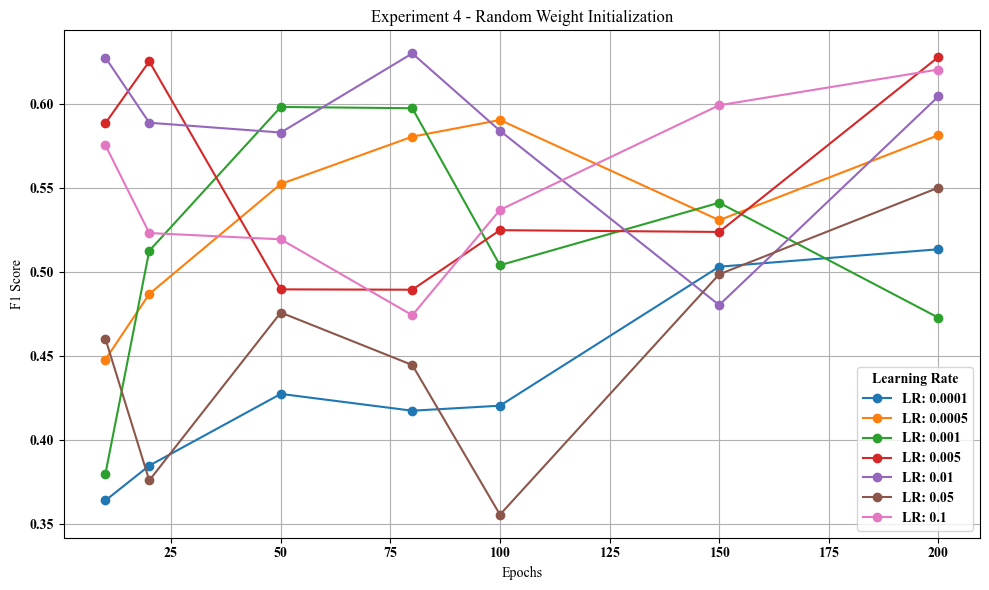

In [17]:
# Plot 1: Epochs vs F1 Score for different learning rates
plt.figure(figsize=(10, 6))
for lr in learning_rates:
    plt.plot(epochs_list, f1_scores_by_epochs_exp4[lr], marker='o', label=f'LR: {lr}')

plt.title('Experiment 4 - Random Weight Initialization')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# Display the best model based on F1 Score
print('Best Model Parameters with Random Weight Initialization:')
print(f'Learning Rate: {best_model_params[0]}, Epochs: {best_model_params[1]}')
print(f'Accuracy: {best_model_params[2]*100:.2f}%')
print(f'Precision: {best_model_params[3]*100:.2f}%')
print(f'Recall: {best_model_params[4]*100:.2f}%')
print(f'F1 Score: {best_model_params[5]*100:.2f}%')

Best Model Parameters with Random Weight Initialization:
Learning Rate: 0.01, Epochs: 80
Accuracy: 73.35%
Precision: 64.48%
Recall: 64.68%
F1 Score: 63.04%


#### 4.5 Performing Experiment 5 - Sigmoid activation function with mini-batch gradient descent

In [19]:
# Convergence threshold 
convergence_threshold = 1e-4
# Define learning rates and epochs
learning_rates = [0.0001,0.0005,0.001, 0.005, 0.01, 0.05, 0.1]
epochs_list = [10, 20, 50, 80, 100, 150, 200]

# Store experimental results and metrics
experiment_results = []
metrics_by_lr_epoch = []  # Store metrics for learning rate, epochs
best_f1 = 0
best_model_params = None

# Initialize a dictionary to store metrics for plotting
f1_scores_by_epochs_exp5 = {lr: [] for lr in learning_rates}  # F1 scores for plotting

# Stratified k-fold setup
k = 5  # 5 stratified folds
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

# Perceptron class with Sigmoid activation and convergence condition
class PerceptronWithSigmoid:
    def __init__(self, input_dim, learning_rate=0.01):
        self.weights = torch.zeros(input_dim + 1, dtype=torch.float32)  # +1 for bias
        self.learning_rate = learning_rate
    
    def sigmoid(self, z):
        return 1 / (1 + torch.exp(-z))

    def predict(self, x):
        x_with_bias = torch.cat((torch.ones(1), x))
        linear_output = torch.dot(self.weights, x_with_bias)
        return 1 if self.sigmoid(linear_output) >= 0.5 else 0
    
    def fit(self, data_loader, epochs=10, convergence_threshold=None):
        previous_f1 = 0
        for epoch in range(epochs):
            epoch_predictions = []
            true_labels = []
            for inputs, label in data_loader:
                for i in range(inputs.shape[0]):
                    x = inputs[i]
                    y = label[i].item()
                    prediction = self.predict(x)
                    epoch_predictions.append(prediction)
                    true_labels.append(y)
                    
                    # Update weights if there's a misclassification
                    if prediction != y:
                        update = self.learning_rate * (y - prediction)
                        x_with_bias = torch.cat((torch.ones(1), x))
                        self.weights += update * x_with_bias

            # Check convergence after each epoch (based on F1 score)
            accuracy, precision, recall, f1 = calculate_metrics(true_labels, epoch_predictions)
            if convergence_threshold and abs(f1 - previous_f1) < convergence_threshold:
                break
            previous_f1 = f1

# Perform stratified k-fold cross-validation
for lr in learning_rates:
    for epochs in epochs_list:
        fold_accuracy_list = []
        fold_precision_list = []
        fold_recall_list = []
        fold_f1_list = []

        for train_index, val_index in skf.split(X_train_transformed, y_train):
            X_train_fold, X_val_fold = X_train_transformed[train_index], X_train_transformed[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            train_dataset = DiabetesDataset(X_train_fold, y_train_fold)
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Using mini-batch

            # Initialize Perceptron with Sigmoid activation function and current learning rate
            experiment_perceptron = PerceptronWithSigmoid(input_dim=input_dim, learning_rate=lr)
            
            # Train the perceptron with sigmoid activation and convergence condition
            experiment_perceptron.fit(train_loader, epochs=epochs, convergence_threshold=convergence_threshold)
            
            # Test the perceptron
            y_pred_fold = [experiment_perceptron.predict(torch.tensor(x, dtype=torch.float32)) for x in X_val_fold]
            
            # Calculate performance metrics
            accuracy_fold, precision_fold, recall_fold, f1_fold = calculate_metrics(y_val_fold, y_pred_fold)
            
            fold_accuracy_list.append(accuracy_fold)
            fold_precision_list.append(precision_fold)
            fold_recall_list.append(recall_fold)
            fold_f1_list.append(f1_fold)
        
        # Calculate average metrics across all folds
        avg_accuracy = np.mean(fold_accuracy_list)
        avg_precision = np.mean(fold_precision_list)
        avg_recall = np.mean(fold_recall_list)
        avg_f1 = np.mean(fold_f1_list)

        # Store results
        experiment_results.append((lr, epochs, avg_accuracy, avg_precision, avg_recall, avg_f1))
        f1_scores_by_epochs_exp5[lr].append(avg_f1)

        # Track the best model based on F1 Score
        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_model_params = (lr, epochs, avg_accuracy, avg_precision, avg_recall, avg_f1)

# Display the experimental results
print('Sigmoid activation Experimental Model Results:')
for lr, epochs, accuracy, precision, recall, f1 in experiment_results:
    print(f'Learning Rate: {lr}, Epochs: {epochs}')
    print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

Sigmoid activation Experimental Model Results:
Learning Rate: 0.0001, Epochs: 10
Accuracy: 0.66, Precision: 0.67, Recall: 0.55, F1 Score: 0.48
Learning Rate: 0.0001, Epochs: 20
Accuracy: 0.64, Precision: 0.65, Recall: 0.50, F1 Score: 0.45
Learning Rate: 0.0001, Epochs: 50
Accuracy: 0.71, Precision: 0.56, Recall: 0.79, F1 Score: 0.65
Learning Rate: 0.0001, Epochs: 80
Accuracy: 0.69, Precision: 0.63, Recall: 0.65, F1 Score: 0.57
Learning Rate: 0.0001, Epochs: 100
Accuracy: 0.70, Precision: 0.69, Recall: 0.55, F1 Score: 0.52
Learning Rate: 0.0001, Epochs: 150
Accuracy: 0.71, Precision: 0.69, Recall: 0.60, F1 Score: 0.57
Learning Rate: 0.0001, Epochs: 200
Accuracy: 0.73, Precision: 0.67, Recall: 0.58, F1 Score: 0.59
Learning Rate: 0.0005, Epochs: 10
Accuracy: 0.73, Precision: 0.78, Recall: 0.32, F1 Score: 0.43
Learning Rate: 0.0005, Epochs: 20
Accuracy: 0.72, Precision: 0.71, Recall: 0.50, F1 Score: 0.53
Learning Rate: 0.0005, Epochs: 50
Accuracy: 0.72, Precision: 0.68, Recall: 0.61, F1 Sc

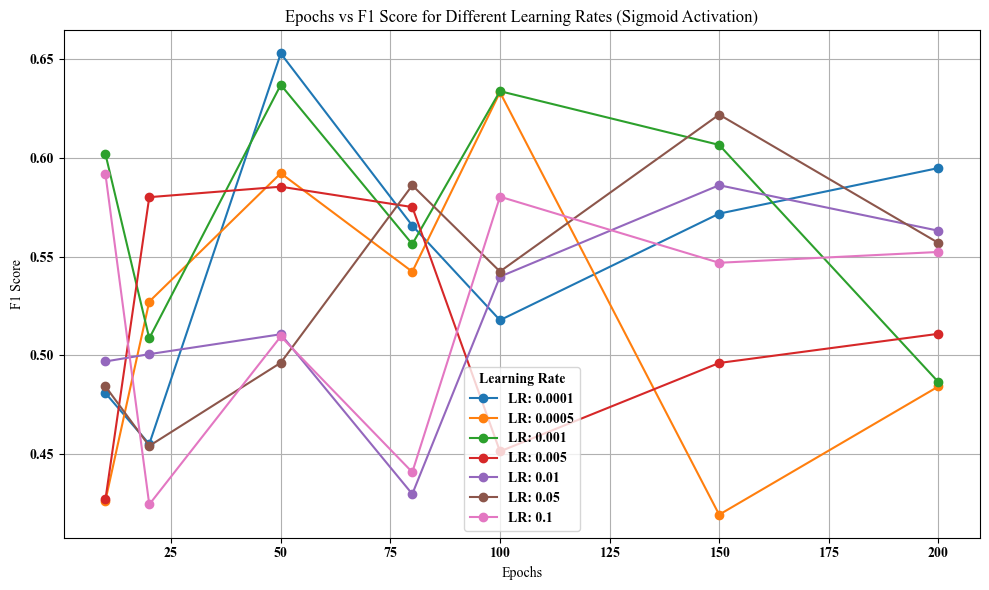

In [20]:
# Plot F1 scores for different learning rates over epochs
plt.figure(figsize=(10, 6))
for lr in learning_rates:
    plt.plot(epochs_list, f1_scores_by_epochs_exp5[lr], marker='o', label=f'LR: {lr}')

plt.title('Epochs vs F1 Score for Different Learning Rates (Sigmoid Activation)')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# Display the best model based on F1 Score
print('Best Model Parameters with Sigmoid Activation:')
print(f'Learning Rate: {best_model_params[0]}, Epochs: {best_model_params[1]}')
print(f'Accuracy: {best_model_params[2]*100:.2f}%')
print(f'Precision: {best_model_params[3]*100:.2f}%')
print(f'Recall: {best_model_params[4]*100:.2f}%')
print(f'F1 Score: {best_model_params[5]*100:.2f}%')

Best Model Parameters with Sigmoid Activation:
Learning Rate: 0.0001, Epochs: 50
Accuracy: 70.68%
Precision: 55.71%
Recall: 79.15%
F1 Score: 65.31%


##### Experimental results for all the models 

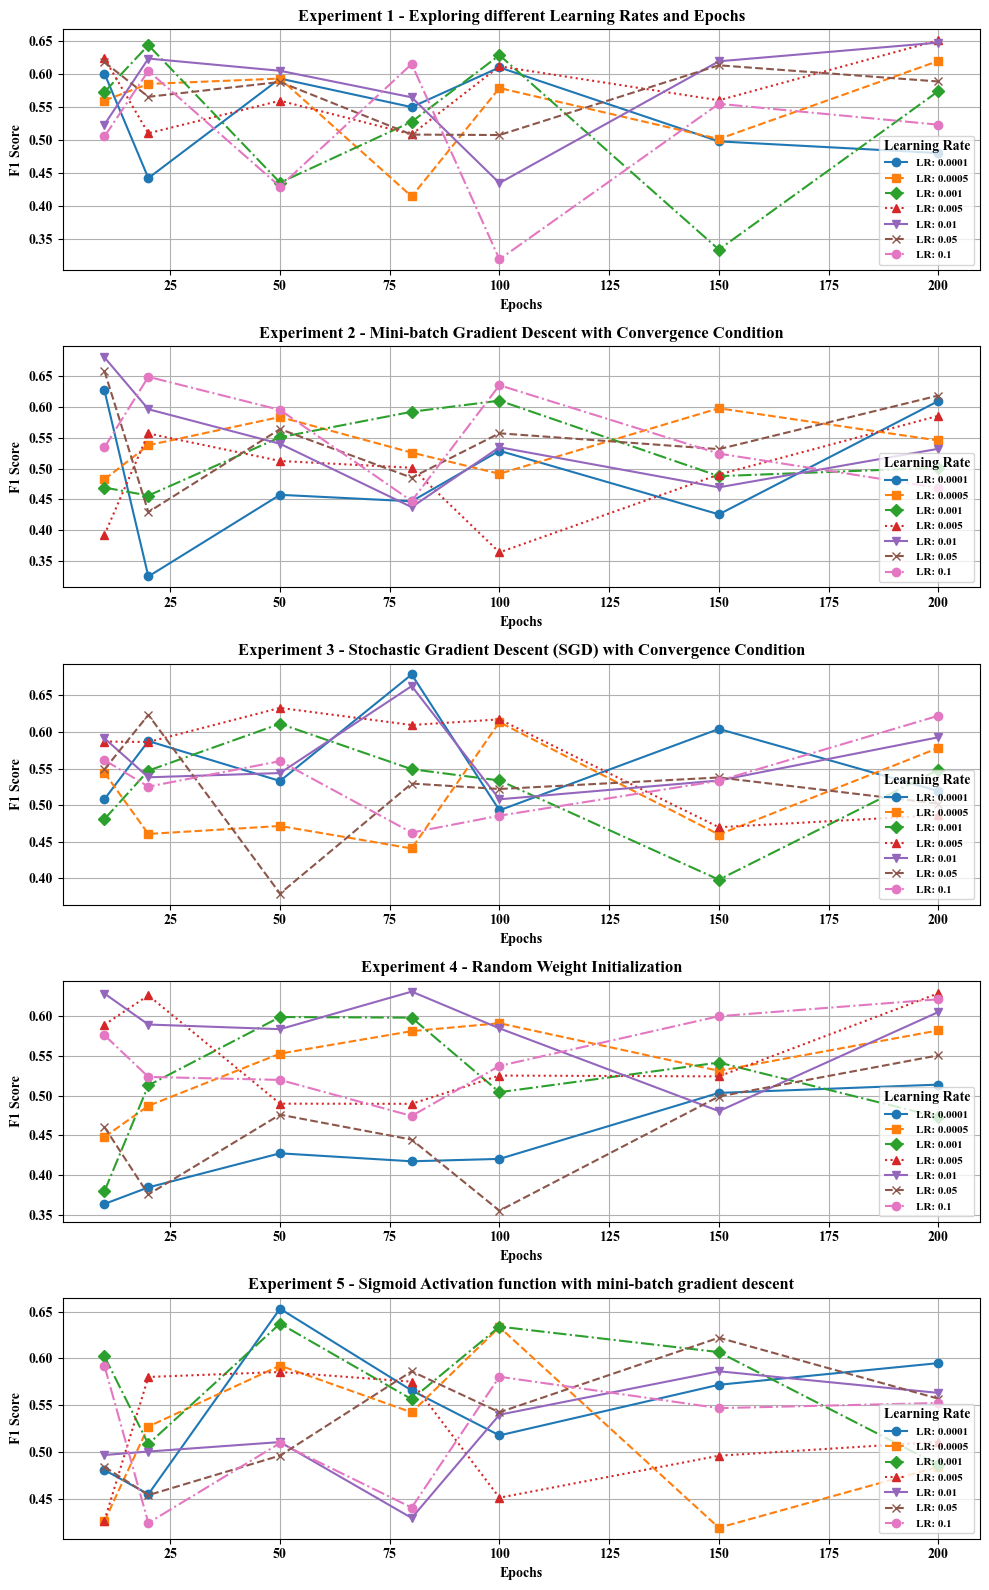

In [22]:
# Titles for each subplot based on the experiments
titles = [
    'Experiment 1 - Exploring different Learning Rates and Epochs',
    'Experiment 2 - Mini-batch Gradient Descent with Convergence Condition',
    'Experiment 3 - Stochastic Gradient Descent (SGD) with Convergence Condition',
    'Experiment 4 - Random Weight Initialization',
    'Experiment 5 - Sigmoid Activation function with mini-batch gradient descent'
]

# Custom line styles and markers for better visual distinction
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', 'D', '^', 'v', 'x']

f1_scores_list = [f1_scores_by_epochs_exp1, f1_scores_by_epochs_exp2, f1_scores_by_epochs_exp3, f1_scores_by_epochs_exp4, f1_scores_by_epochs_exp5]

fig, axes = plt.subplots(len(f1_scores_list), 1, figsize=(10, 16))

# Loop through each experiment and plot its F1 scores
for i, ax in enumerate(axes):
    f1_scores = f1_scores_list[i]  # Get the F1 scores for the current experiment
    
    for j, lr in enumerate(learning_rates):
        # Apply custom line styles and markers for each learning rate
        ax.plot(epochs_list, f1_scores[lr], marker=markers[j % len(markers)], linestyle=line_styles[j % len(line_styles)], label=f'LR: {lr}')
    
    ax.set_title(titles[i], fontsize=12, weight='bold')
    ax.set_xlabel('Epochs', fontsize=10, weight='bold')
    ax.set_ylabel('F1 Score', fontsize=10, weight='bold')
    ax.grid(True)
    ax.legend(title='Learning Rate', loc='best', fontsize=8)

plt.tight_layout()
plt.show()


#### 4.6 Best model results using test data

In [23]:
learning_rate = 0.001  # Best learning rate from Experiment 2
epochs = 100  # Best number of epochs from Experiment 2
batch_mode = True # Use mini-batch 
convergence_threshold = 1e-4  

# Re-initialize the best perceptron with convergence
best_perceptron = PerceptronWithConvergence(input_dim, learning_rate=learning_rate)

# Train the perceptron using the best parameters
best_perceptron.fit(train_loader, epochs=epochs, batch_mode=batch_mode, convergence_threshold=convergence_threshold)

# Use the trained model to predict the test set
y_pred_test = [best_perceptron.predict(torch.tensor(x, dtype=torch.float32)) for x in X_test_transformed]

# Calculate performance metrics for the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, zero_division=0)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

# Print the final test set results
print('Best Model Performance on Test Set:')
print(f'Accuracy: {test_accuracy * 100:.2f}%')
print(f'Precision: {test_precision * 100:.2f}%')
print(f'Recall: {test_recall * 100:.2f}%')
print(f'F1 Score: {test_f1 * 100:.2f}%')

Best Model Performance on Test Set:
Accuracy: 68.75%
Precision: 53.33%
Recall: 72.73%
F1 Score: 61.54%
